In [64]:
import json
import glob
import pickle
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def to_sec(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').timestamp()
    except:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f').timestamp()

sns.set()
sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
# matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

In [2]:
def plot_reward_vs_time(data, PLOT_DIR):
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    x = times
    y = data['raw_rewards']
    plt.figure(figsize=(8.5, 6))

    plt.plot(x, y, 'o', markersize=3)
    plt.ylabel('Reward (-MAE)')
    plt.xlabel('Time (sec)')

    plt.xlim(left=0)
    plt.locator_params(axis='y', nbins=6)
    plt.savefig(PLOT_DIR+'reward.png', dpi=300)

In [3]:
def random_seed_results(DATA_DIR):
    y_true1 = []
    y_pred1 = []
    y_true2 = []
    y_pred2 = []
    y_true3 = []
    y_pred3 = []
    for file in [DATA_DIR+'best_archs_result_0_2020.pickle',DATA_DIR+'best_archs_result_0_2021.pickle',DATA_DIR+'best_archs_result_0_2022.pickle']:
        with open(file, 'rb') as f:
            _ = pickle.load(f)
            y_true1.append(pickle.load(f))
            y_pred1.append(pickle.load(f))
            y_true2.append(pickle.load(f))
            y_pred2.append(pickle.load(f))
            y_true3.append(pickle.load(f))
            y_pred3.append(pickle.load(f))

    mae10 = mean_absolute_error(y_true1[0], y_pred1[0])
    mae11 = mean_absolute_error(y_true1[1], y_pred1[1])
    mae12 = mean_absolute_error(y_true1[2], y_pred1[2])
    mae20 = mean_absolute_error(y_true2[0], y_pred2[0])
    mae21 = mean_absolute_error(y_true2[1], y_pred2[1])
    mae22 = mean_absolute_error(y_true2[2], y_pred2[2])
    mae30 = mean_absolute_error(y_true3[0], y_pred3[0])
    mae31 = mean_absolute_error(y_true3[1], y_pred3[1])
    mae32 = mean_absolute_error(y_true3[2], y_pred3[2])

    mae_train_mean = np.mean([mae10, mae20, mae30])
    mae_valid_mean = np.mean([mae11, mae21, mae31])
    mae_test_mean = np.mean([mae12, mae22, mae32])
    mae_train_std = np.std([mae10, mae20, mae30])
    mae_valid_std = np.std([mae11, mae21, mae31])
    mae_test_std = np.std([mae12, mae22, mae32])
    return mae_train_mean, mae_train_std, mae_valid_mean, mae_valid_std, mae_test_mean, mae_test_std

In [4]:
def parity_results(DATA_DIR):
    y_true1 = []
    y_pred1 = []
    y_true2 = []
    y_pred2 = []
    y_true3 = []
    y_pred3 = []
    for file in [DATA_DIR+'best_archs_result_0_2020.pickle',DATA_DIR+'best_archs_result_0_2021.pickle',DATA_DIR+'best_archs_result_0_2022.pickle']:
        with open(file, 'rb') as f:
            _ = pickle.load(f)
            y_true1.append(pickle.load(f))
            y_pred1.append(pickle.load(f))
            y_true2.append(pickle.load(f))
            y_pred2.append(pickle.load(f))
            y_true3.append(pickle.load(f))
            y_pred3.append(pickle.load(f))
    return y_true1, y_pred1, y_true2, y_pred2, y_true3, y_pred3

In [5]:
state_dims = [8, 16, 32]
Ts = [1, 2, 3]
attn_methods = ['const', 'gcn', 'gat', 'sym-gat']
attn_heads = [1, 2, 4, 6]
aggr_methods = ['max', 'mean', 'sum']
update_methods = ['gru', 'mlp']
activations = ['sigmoid', 'tanh', 'relu', 'elu']
out = []
for state_dim in state_dims:
    for T in Ts:
        for attn_method in attn_methods:
            for attn_head in attn_heads:
                for aggr_method in aggr_methods:
                    for update_method in update_methods:
                        for activation in activations:
                            out.append([state_dim, T, attn_method, attn_head, aggr_method, update_method, activation])

out_pool = []
for functions in ['GlobalSumPool', 'GlobalMaxPool', 'GlobalAvgPool']:
    for axis in ['-1', '-2']:  # Pool in terms of nodes or features
        out_pool.append(functions+axis)
out_pool.append('flatten')

out_connect = ['skip', 'connect']

def get_gat(index):
    return out[index]
def get_pool(index):
    return out_pool[index]
def get_connect(index):
    return out_connect[index]


def create_csv(DATA_DIR, data):
    archs = np.array(data['arch_seq'])
    rewards = np.array(data['raw_rewards'])
    a = np.empty((len(archs),0), dtype=np.object)
    a = np.append(a, archs, axis=-1)
    a = np.append(a, rewards[..., np.newaxis], axis=-1)
    b = np.empty((0,29), dtype=np.object)
    for i in range(len(a)):
        temp = a[i, :]
        b0 = get_gat(temp[0])
        b1 = [get_connect(temp[1])]
        b2 = get_gat(temp[2])
        b3 = [get_connect(temp[3])]
        b4 = [get_connect(temp[4])]
        b5 = get_gat(temp[5])
        b6 = [get_connect(temp[6])]
        b7 = [get_connect(temp[7])]
        b8 = [get_connect(temp[8])]
        b9 = [get_pool(temp[9])]
        bout = b0+b1+b2+b3+b4+b5+b6+b7+b8+b9+[temp[10]]
        bout = np.array(bout, dtype=object)
        b = np.append(b, bout[np.newaxis, ...], axis=0)
    table = pd.DataFrame(data=b)
    table.to_csv(DATA_DIR + 'nas_result.csv', encoding='utf-8', index=False, header=False)

In [6]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    df_new.columns = [                'dim-1',                 'pass-1',           'const-1',
                   'gat-1',             'gcn-1',         'sym-gat-1',
                       'head-1',             'max-1',            'mean-1',
                   'sum-1',             'gru-1',             'mlp-1',
                   'elu-1',            'relu-1',         'sigmoid-1',
                  'tanh-1',         'connect-1',            'skip-1',
                       'dim-2',                 'pass-2',           'const-2',
                   'gat-2',             'gcn-2',         'sym-gat-2',
                      'sym-gat-2',             'max-2',            'mean-2',
                   'sum-2',             'gru-2',             'mlp-2',
                   'elu-2',            'relu-2',         'sigmoid-2',
                  'tanh-2',         'connect-2',            'skip-2',
               'connect-3',            'skip-3',                'dim-3',
                      'pass-3',           'const-3',             'gat-3',
                   'gcn-3',         'sym-gat-3',                'head-3',
                   'max-3',            'mean-3',             'sum-3',
                   'gru-3',             'mlp-3',             'elu-3',
                  'relu-3',         'sigmoid-3',            'tanh-3',
               'connect-4',            'skip-4',         'connect-5',
                  'skip-5',         'connect-6',            'skip-6',
       'GlobalAvgPool-1', 'GlobalAvgPool-2', 'GlobalMaxPool-1',
       'GlobalMaxPool-2', 'GlobalSumPool-1', 'GlobalSumPool-2',
               'flatten',                'reward']
    X,y = df_new.values[:,0:66], df_new.values[:,67]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(8,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    print(df.values[np.argmax(y),:])

# QM7

In [7]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/qm7/"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0708/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-08_18.json')

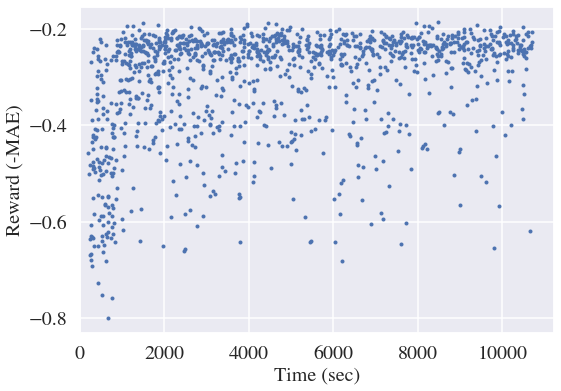

In [8]:
plot_reward_vs_time(QM7_data, QM7_PLOT_DIR)

In [9]:
mae_train_mean, mae_train_std, mae_valid_mean, mae_valid_std, mae_test_mean, mae_test_std = random_seed_results(QM7_DATA_DIR)

In [10]:
print(f"Train MAE: {mae_train_mean:0.5f} +/- {mae_train_std:0.5f}")
print(f"Valid MAE: {mae_valid_mean:0.5f} +/- {mae_valid_std:0.5f}")
print(f"Test MAE: {mae_test_mean:0.5f} +/- {mae_test_std:0.5f}")

print(f"MolNet Train MAE: {67.8:0.5f} +/- {4:0.5f}")
print(f"MolNet Valid MAE: {77.9:0.5f} +/- {10:0.5f}")
print(f"MolNet Test MAE: {77.9:0.5f} +/- {2.1:0.5f}")

Train MAE: 41.16294 +/- 4.35162
Valid MAE: 39.23183 +/- 3.78732
Test MAE: 39.90304 +/- 3.85995
MolNet Train MAE: 67.80000 +/- 4.00000
MolNet Valid MAE: 77.90000 +/- 10.00000
MolNet Test MAE: 77.90000 +/- 2.10000


[32 1 'gcn' 2 'max' 'mlp' 'relu' 'connect' 32 2 'const' 4 'mean' 'gru'
 'tanh' 'skip' 'connect' 32 2 'const' 1 'sum' 'gru' 'elu' 'connect' 'skip'
 'connect' 'GlobalSumPool-2' -0.18447165191173556]


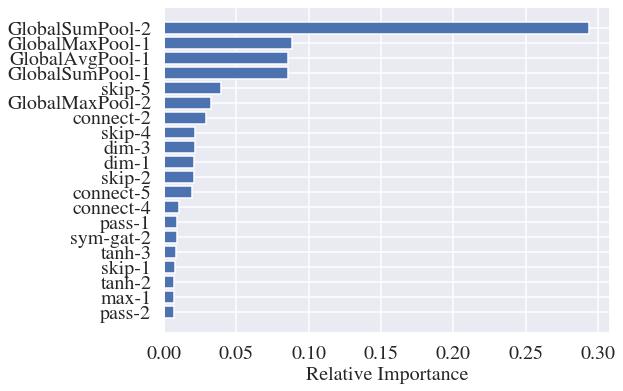

In [11]:
create_csv(QM7_DATA_DIR, QM7_data)
feature_importance(QM7_DATA_DIR, QM7_PLOT_DIR)

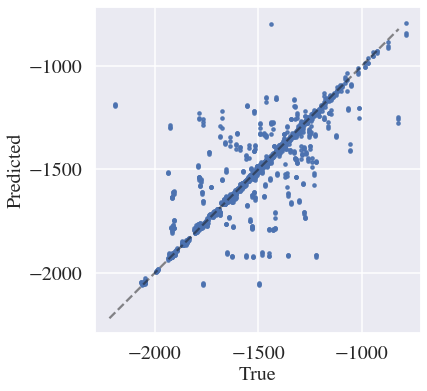

In [67]:
_, _, _, _, y_true, y_pred = parity_results(QM7_DATA_DIR)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
plt.figure(figsize=(8,6))
min_value = np.min([y_true.min(), y_pred.min()])
max_value = np.max([y_true.max(), y_pred.max()])
dist = max_value - min_value
min_value -= 0.02*dist
max_value += 0.02*dist
plt.plot(np.arange(min_value, max_value, 100), np.arange(min_value, max_value, 100), 'k--', alpha=0.5)
plt.scatter(y_true.ravel(), y_pred.ravel(), s=10, alpha=0.9)
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis("square")
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.savefig(QM7_PLOT_DIR + "parity_plot.png")

# QM8

In [68]:
QM8_PLOT_DIR = r"/mnt/d/plots/anl/qm8/"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0708/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-08_14.json')

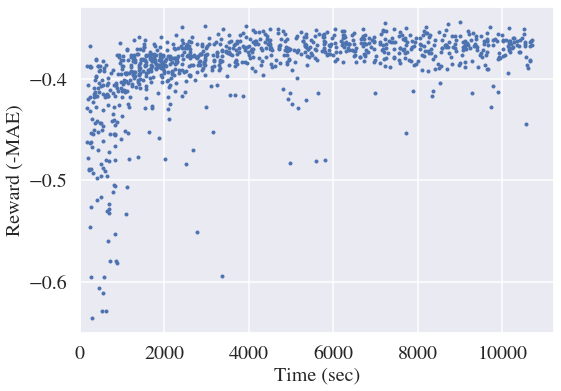

In [69]:
plot_reward_vs_time(QM8_data, QM8_PLOT_DIR)

In [70]:
mae_train_mean, mae_train_std, mae_valid_mean, mae_valid_std, mae_test_mean, mae_test_std = random_seed_results(QM8_DATA_DIR)

In [71]:
print(f"Train MAE: {mae_train_mean:0.5f} +/- {mae_train_std:0.5f}")
print(f"Valid MAE: {mae_valid_mean:0.5f} +/- {mae_valid_std:0.5f}")
print(f"Test MAE: {mae_test_mean:0.5f} +/- {mae_test_std:0.5f}")

print(f"MolNet Train MAE: {0.0128:0.5f} +/- {0.001:0.5f}")
print(f"MolNet Valid MAE: {0.0146:0.5f} +/- {0.001:0.5f}")
print(f"MolNet Test MAE: {0.0143:0.5f} +/- {0.0011:0.5f}")

Train MAE: 0.01213 +/- 0.00034
Valid MAE: 0.01211 +/- 0.00028
Test MAE: 0.01213 +/- 0.00034
MolNet Train MAE: 0.01280 +/- 0.00100
MolNet Valid MAE: 0.01460 +/- 0.00100
MolNet Test MAE: 0.01430 +/- 0.00110


[32 1 'gcn' 2 'sum' 'gru' 'tanh' 'connect' 16 2 'gat' 2 'mean' 'mlp' 'elu'
 'connect' 'skip' 32 3 'sym-gat' 6 'sum' 'mlp' 'tanh' 'connect' 'skip'
 'connect' 'GlobalMaxPool-2' -0.34357380867004395]


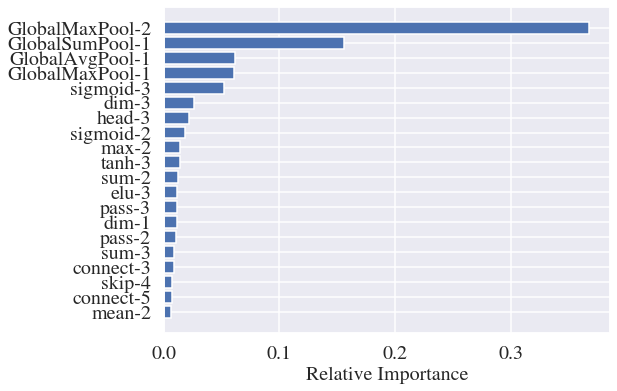

In [72]:
create_csv(QM8_DATA_DIR, QM8_data)
feature_importance(QM8_DATA_DIR, QM8_PLOT_DIR)

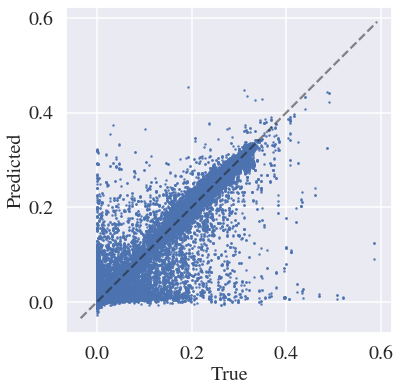

In [79]:
_, _, _, _, y_true, y_pred = parity_results(QM8_DATA_DIR)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
plt.figure(figsize=(8,6))
min_value = np.min([y_true.min(), y_pred.min()])
max_value = np.max([y_true.max(), y_pred.max()])
dist = max_value - min_value
min_value -= 0.01*dist
max_value += 0.01*dist
plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
plt.scatter(y_true.ravel(), y_pred.ravel(), s=1, alpha=0.9)
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis("square")
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.savefig(QM8_PLOT_DIR + "parity_plot.png")

In [77]:
y_true.shape

(3, 2179, 16)